In [1]:
# Data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pyvis.network import Network

# Graph Creation
import ast
import networkx as nx

import torch

from sklearn.model_selection import train_test_split

# NLP
from transformers import BartTokenizer, BartModel
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import RobertaTokenizer, RobertaModel

# from pyclustertend import vat, ivat

from sentence_transformers import SentenceTransformer

# sklearn
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS, Birch, HDBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer

# Other
import warnings, sys, os, random, math
from tqdm import tqdm
import textwrap

import spacy

sys.path.append(os.path.abspath('package'))

from package.hierarchical_graph import HierarchicalGraphBuilder, CallGraphBuilder
from package.code_normalizer import CodeNormalizer


# SETTINGS
pd.set_option('display.max_columns', 70)
warnings.filterwarnings("ignore")

C:\Users\szmid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Question keywoord getter

In [161]:

# Load the English model from spaCy
nlp = spacy.load("en_core_web_sm")

def extract_keywords(question: str, min_token_len: int = 2) -> list:
    """
    Extract important words from a programming-related question.
    Filters out stopwords, punctuation, and selects key POS tags (nouns, verbs, adjectives).
    
    Args:
        question (str): Input question string.
        min_token_len (int): Minimum length of a word to be considered.

    Returns:
        List of important keywords.
    """
    doc = nlp(question)
    
    # Keep tokens that are nouns, proper nouns, verbs, adjectives
    keywords = [
        token.text for token in doc
        if token.is_alpha and not token.is_stop and len(token.text) >= min_token_len
        and token.pos_ in {"NOUN", "PROPN", "VERB", "ADJ"}
    ]
    
    return keywords

# Example usage
question = "get the logistic regression fuctions from the repository"
keywords = extract_keywords(question)

print("Extracted keywords:", keywords)


Extracted keywords: ['logistic', 'regression', 'fuctions', 'repository']


### Cluster retrieval

In [162]:
# Update the summaries in the DataFrame based on the cluster_summaries dictionary
cdf = pd.read_csv('kg_rag_df.csv')
cdf['summary']

0                                                  Random
1                                                  Random
2                                                  Random
3                                                  Random
4                                                  Random
                              ...                        
5829                                      Test functions.
5830    This cluster captures the prediction part of d...
5831                                      Test functions.
5832                                      Test functions.
5833    This cluster encompasses error handling and va...
Name: summary, Length: 5834, dtype: object

In [129]:
cdf['summary'] = cdf['summary'].replace(
    'This cluster encompasses the training and fitting methods related to different models in scikit-learn, focusing on the fit, partial fit (partial_fit), fit_predict and fit_trainsform methods.',
    'Training and fitting methods related to different regression, classification, supervised and unsuervised models in scikit-learn, focusing on the fit, partial fit (partial_fit), fit_predict and fit_trainsform methods.',
)

cdf.to_csv('kg_rag_df.csv', index=False)

In [163]:
#cdf['summary'] = cdf['summary'].str.replace('Fit functions', 'Fit/training functions', regex=False)
clusters = cdf['summary'].unique().tolist()
clusters

['Random',
 'Sklearn tags.',
 'This cluster lists and stores all evaluation metrics and scoring functions in the repository, created for model evaluation in classification, regression, clustering, anomaly detection, etc.',
 'This cluster captures the prediction part of different models after training (trained models), focusing on methods like predict, predict probability (predict_proba), and predicting log probability (predict_log_proba).',
 'This cluster captures the transformation pipeline of scikit-learn, including transform, fit_transform, and inverse_transform methods for a wide range of transformers, decomposers, and preprocessors, along with corresponding test coverage and utility support.',
 'This cluster is centered on generating and validating output feature names in transformers and pipelines, including support for get_feature_names_out, handling feature name propagation, prefixing, and ensuring compatibility with various data formats like pandas and NumPy.',
 'Test function

In [164]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(clusters, convert_to_tensor=True).cpu().tolist()
embeddings

[[-0.02194356359541416,
  -0.03079894185066223,
  -0.021427014842629433,
  0.08138976246118546,
  0.0033614588901400566,
  -0.047324419021606445,
  0.13399657607078552,
  -0.028732405975461006,
  0.11314066499471664,
  0.03610590472817421,
  0.004780004732310772,
  -0.021258534863591194,
  -0.014881028793752193,
  -0.022240648046135902,
  -0.07932104915380478,
  -0.011845367960631847,
  -0.014927628450095654,
  -0.06917022913694382,
  -0.07255278527736664,
  -0.00012153590068919584,
  -0.04087388888001442,
  -0.03144380822777748,
  0.013111553154885769,
  -0.013547049835324287,
  -0.021893516182899475,
  -0.07807387411594391,
  0.053609635680913925,
  0.03520411252975464,
  0.029430696740746498,
  -0.1022142544388771,
  0.03660140559077263,
  0.03740311786532402,
  -0.008580753579735756,
  -0.041749946773052216,
  -0.007917558774352074,
  -0.02442052587866783,
  -0.08625657856464386,
  0.0052126748487353325,
  0.00758610013872385,
  0.015888946130871773,
  -0.005727361887693405,
  -0.0

<Axes: >

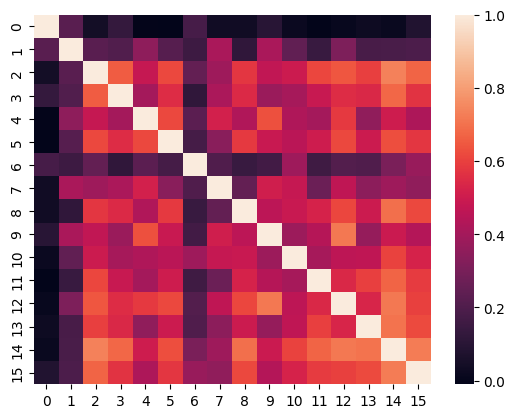

In [165]:
# cosine similarity matrix
cosine_sim = metrics.pairwise.cosine_similarity(embeddings)
sns.heatmap(cosine_sim)

In [166]:
# concat keywords to one string with spaces
keyword_string = ' '.join(keywords)
keyword_string

'logistic regression fuctions repository'

In [167]:
keyword_embeddings = model.encode(keyword_string, convert_to_tensor=True).cpu().tolist()
keyword_embeddings

[-0.005463949870318174,
 -0.09561208635568619,
 -0.07391618937253952,
 0.02772531472146511,
 0.08821108937263489,
 -0.06446973979473114,
 -0.014676462858915329,
 -0.009980711154639721,
 -0.08600005507469177,
 0.0818927213549614,
 0.07160336524248123,
 -0.07214292138814926,
 -0.036488745361566544,
 0.0013067112304270267,
 -0.024692369624972343,
 0.026163116097450256,
 -0.028200235217809677,
 0.045464932918548584,
 0.0014229550724849105,
 0.00010995936463586986,
 -0.05721148103475571,
 0.041572749614715576,
 0.020548634231090546,
 -0.02169923298060894,
 0.049571696668863297,
 -0.11430884897708893,
 -0.019965194165706635,
 0.05426643788814545,
 -0.06316476315259933,
 -0.06901702284812927,
 -0.06106988713145256,
 0.027995971962809563,
 0.06125684827566147,
 0.034705691039562225,
 0.01769407093524933,
 -0.009382585994899273,
 0.025547150522470474,
 -0.009149354882538319,
 0.0046282620169222355,
 0.031690195202827454,
 -0.08955579251050949,
 -0.06879734247922897,
 0.056111890822649,
 -0.0646

<Axes: >

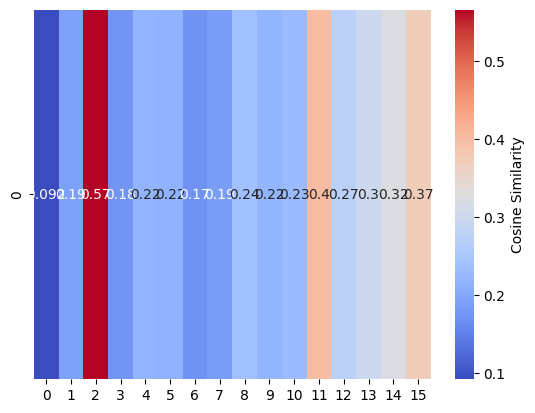

In [160]:
# Check cosine similarity between keyword embeddings and cluster embeddings
cosine_sim_keyword = metrics.pairwise.cosine_similarity([keyword_embeddings], embeddings)
sns.heatmap(cosine_sim_keyword, annot=True, cmap='coolwarm', cbar_kws={'label': 'Cosine Similarity'})

In [98]:
# Get top 3 most similar elements
top_clusters = np.argsort(cosine_sim_keyword[0])[-3:][::-1]  # Get indices of top 5 most similar elements
pd.DataFrame(clusters).iloc[top_clusters].to_numpy().tolist()

[['This cluster captures the prediction phase of models, focusing on methods like predict, predict_proba, and predict_log_proba, including both core implementations and tests across classifiers, regressors, and clustering algorithms.'],
 ['This list contains various functions and methods primarily focused on data splitting, cross-validation, and train-test partitioning techniques commonly used in machine learning workflows.'],
 ['This cluster encompasses the .fit and .partial_fit methods across a wide variety of scikit-learn estimators, representing the model training phase for classifiers, regressors, transformers, pipelines, and unsupervised learning components.']]

### Docstring embedding retrieval

In [ ]:
cgn = pd.read_csv('graph/sklearn/cg_nodes.csv')
docstring_embeddings = cgn['docstring_embedding'].apply(ast.literal_eval).tolist()

<Axes: >

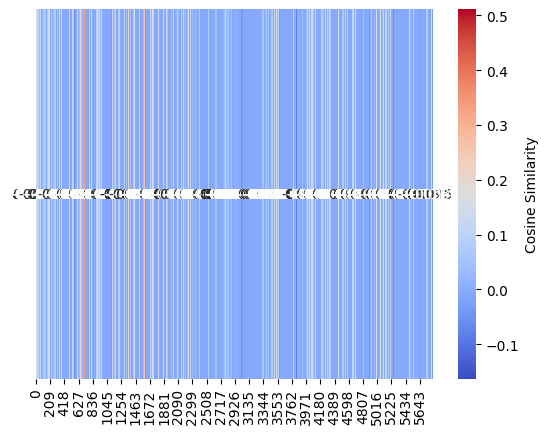

In [ ]:
# Check cosine similarity between keyword embeddings and cluster embeddings
cosine_sim_keyword = metrics.pairwise.cosine_similarity([keyword_embeddings], docstring_embeddings)
sns.heatmap(cosine_sim_keyword, annot=True, cmap='coolwarm', cbar_kws={'label': 'Cosine Similarity'})

In [ ]:
# Get the top 5 most similar elements
top_indices = np.argsort(cosine_sim_keyword[0])[-10:][::-1]
cgn.iloc[top_indices]

,combinedName,function_code,docstring,docstring_embedding,func_id
2119,test_partial_dependence_kind_list,"def test_partial_dependence_kind_list(pyplot, ...",Check that we can provide a list of strings to...,"[0.0379401333630085, 0.03714059665799141, -0.0...",2119
1513,isdtype,"def isdtype(dtype: DType, kind: DType | str | ...",Returns a boolean indicating whether a provide...,"[0.026074783876538277, 0.007953491061925888, -...",1513
1569,isdtype,"def isdtype(dtype: DType, kind: Union[DType, s...",Returns a boolean indicating whether a provide...,"[0.026074783876538277, 0.007953491061925888, -...",1569
1538,__array_namespace_info__.dtypes,"def dtypes(self, *, device=None, kind=None):\n...",The array API data types supported by CuPy.\n\...,"[0.04044675454497337, 0.008410784415900707, -0...",1538
1545,__array_namespace_info__.dtypes,"def dtypes(self, /, *, device: _Device | None=...",The array API data types supported by Dask.\n\...,"[0.009290759451687336, 0.0706217810511589, -0....",1545
1500,ArffEncoder._encode_attribute,"def _encode_attribute(self, name, type_):\n ...",(INTERNAL) Encodes an attribute line.\n\nThe a...,"[-0.017525535076856613, 0.06239911541342735, -...",1500
5071,isdtype,"def isdtype(dtype, kind, *, xp):\n """"""Retur...",Returns a boolean indicating whether a provide...,"[0.043678510934114456, 0.011718821711838245, -...",5071
1496,ArffDecoder._decode_attribute,"def _decode_attribute(self, s):\n """"""(INTER...",(INTERNAL) Decodes an attribute line.\n\n ...,"[-0.01643364503979683, 0.03239601105451584, -0...",1496
686,fetch_openml,"@validate_params({'name': [str, None], 'versio...",Fetch dataset from openml by name or dataset i...,"[0.02681341953575611, 0.039047472178936005, -0...",686
713,fetch_species_distributions,"@validate_params({'data_home': [str, PathLike,...",Loader for species distribution dataset from P...,"[-0.03396093472838402, 0.007685221266001463, -...",713


### Structure graph retrieval

In [168]:
struct_g = pd.read_csv('kg_rag_df.csv')
struct_g

,combinedName,function_code,docstring,docstring_embedding,func_id,summary,className
0,clone,"def clone(estimator, *, safe=True):\n """"""Co...",Construct a new unfitted estimator with the sa...,"[-0.13635297119617462, -0.10193724930286407, 0...",0,Random,NaN
1,_clone_parametrized,"def _clone_parametrized(estimator, *, safe=Tru...",Default implementation of clone. See :func:`sk...,"[-0.12790191173553467, -0.0752759575843811, -0...",1,Random,NaN
2,BaseEstimator._get_param_names,@classmethod\ndef _get_param_names(cls):\n ...,Get parameter names for the estimator,"[-0.005924790631979704, -0.017579255625605583,...",2,Random,BaseEstimator
3,BaseEstimator.get_params,"def get_params(self, deep=True):\n """"""\n ...",Get parameters for this estimator.\n\nParamete...,"[-0.0028749655466526747, -0.020313695073127747...",3,Random,BaseEstimator
4,BaseEstimator._get_params_html,"def _get_params_html(self, deep=True):\n """"...",Get parameters for this estimator with a speci...,"[-0.03902079910039902, -0.03539375588297844, -...",4,Random,BaseEstimator
...,...,...,...,...,...,...,...
5829,test_binomial_vs_alternative_formulation,"@pytest.mark.parametrize('y_true', (np.array([...",Test that both formulations of the binomial de...,"[0.0541771799325943, 0.01487375795841217, 0.05...",5829,Test functions.,NaN
5830,test_predict_proba,"@pytest.mark.parametrize('loss', LOSS_INSTANCE...",Test that predict_proba and gradient_proba wor...,"[-0.08995843678712845, -0.11696255952119827, -...",5830,This cluster captures the prediction part of d...,NaN
5831,test_loss_pickle,"@pytest.mark.parametrize('loss', LOSS_INSTANCE...",Test that losses can be pickled.,"[-0.06052705645561218, 0.028919026255607605, 0...",5831,Test functions.,NaN
5832,test_tweedie_log_identity_consistency,"@pytest.mark.parametrize('p', [-1.5, 0, 1, 1.5...",Test for identical losses when only the link f...,"[-0.026912715286016464, 0.008891728706657887, ...",5832,Test functions.,NaN


In [169]:
structure_embeddings = model.encode(struct_g['className'].dropna().drop_duplicates().tolist(), convert_to_tensor=True).cpu().tolist()

<Axes: >

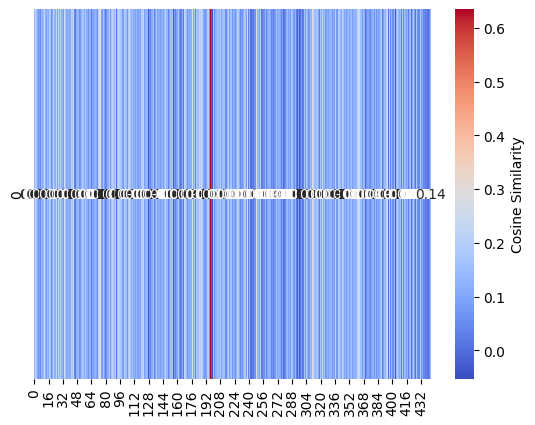

In [170]:
# Check cosine similarity between keyword embeddings and cluster embeddings
cosine_sim_keyword = metrics.pairwise.cosine_similarity([keyword_embeddings], structure_embeddings)
sns.heatmap(cosine_sim_keyword, annot=True, cmap='coolwarm', cbar_kws={'label': 'Cosine Similarity'})

In [172]:
struct_g['className'].dropna().drop_duplicates().tolist()[192:200]

['HuberRegressor',
 'Lars',
 'LarsCV',
 'LassoLarsIC',
 'LinearModelLoss',
 'LogisticRegression',
 'LogisticRegressionCV',
 'OrthogonalMatchingPursuit']

In [174]:
# Get the top 5 most similar elements
top_indices = np.argsort(cosine_sim_keyword[0])[-10:][::-1]  # Get indices of top 5 most similar elements
top_classes = struct_g['className'].dropna().drop_duplicates().reset_index().iloc[top_indices]
struct_g.loc[struct_g['className'].isin(top_classes['className'])]


,combinedName,function_code,docstring,docstring_embedding,func_id,summary,className
568,GraphicalLasso.fit,@_fit_context(prefer_skip_nested_validation=Tr...,Fit the GraphicalLasso model to X.\n\nParamete...,"[-0.011130998842418194, -0.06285949051380157, ...",568,Training and fitting methods related to differ...,GraphicalLasso
570,GraphicalLassoCV.fit,@_fit_context(prefer_skip_nested_validation=Tr...,Fit the GraphicalLasso covariance model to X.\...,"[-0.011492074467241764, -0.08987560868263245, ...",570,Training and fitting methods related to differ...,GraphicalLassoCV
571,GraphicalLassoCV.get_metadata_routing,"def get_metadata_routing(self):\n """"""Get me...",Get metadata routing of this object.\n\nPlease...,"[0.04754064232110977, -0.0346713587641716, -0....",571,Random,GraphicalLassoCV
1870,RBF.__call__,"def __call__(self, X, Y=None, eval_gradient=Fa...","Return the kernel k(X, Y) and optionally its g...","[0.006546566728502512, -0.06379789859056473, -...",1870,Random,RBF
1947,NoTransformIndicatorImputer.fit,"def fit(self, X, y=None):\n mask = _get_mas...",NaN,"[-0.11883842945098877, 0.04829872399568558, -0...",1947,Training and fitting methods related to differ...,NoTransformIndicatorImputer
2148,Lasso.__init__,"def __init__(self, alpha=1.0, *, fit_intercept...",NaN,"[-0.11883842945098877, 0.04829872399568558, -0...",2148,Random,Lasso
2179,LogisticRegression.fit,@_fit_context(prefer_skip_nested_validation=Tr...,Fit the model according to the given training ...,"[-0.002620726590976119, -0.010756628587841988,...",2179,Training and fitting methods related to differ...,LogisticRegression
2180,LogisticRegression.predict_proba,"def predict_proba(self, X):\n """"""\n ...",Probability estimates.\n\nThe returned estimat...,"[-0.013878080062568188, -0.01715906150639057, ...",2180,This cluster captures the prediction part of d...,LogisticRegression
2181,LogisticRegression.__sklearn_tags__,def __sklearn_tags__(self):\n tags = super(...,NaN,"[-0.11883842945098877, 0.04829872399568558, -0...",2181,Sklearn tags.,LogisticRegression
2182,LogisticRegressionCV.fit,@_fit_context(prefer_skip_nested_validation=Tr...,Fit the model according to the given training ...,"[-0.007215481251478195, -0.042094554752111435,...",2182,Training and fitting methods related to differ...,LogisticRegressionCV


### Test

In [31]:
cdf.loc[cdf['summary'] == 'This cluster focuses on the creation, customization, validation, and testing of scoring functions and metrics used to evaluate model performance in scikit-learn.']

,combinedName,function_code,docstring,docstring_embedding,func_id,summary,className
1366,BaseHistGradientBoosting._check_early_stopping...,"def _check_early_stopping_scorer(self, X_binne...",Check if fitting should be early-stopped based...,"[0.025030823424458504, 0.012469811365008354, -...",1366,"This cluster focuses on the creation, customiz...",BaseHistGradientBoosting
1426,test_raw_predict_is_called_with_custom_scorer,def test_raw_predict_is_called_with_custom_sco...,Custom scorer will still call _raw_predict.,"[-0.04711812734603882, -0.050604067742824554, ...",1426,"This cluster focuses on the creation, customiz...",NaN
2185,LogisticRegressionCV._get_scorer,"def _get_scorer(self):\n """"""Get the scorer ...",Get the scorer based on the scoring method spe...,"[0.06316006183624268, 0.015356472693383694, -0...",2185,"This cluster focuses on the creation, customiz...",LogisticRegressionCV
2235,_RidgeGCV._score_without_scorer,"def _score_without_scorer(self, squared_errors...",Performs scoring using squared errors when the...,"[0.053773775696754456, 0.0441451370716095, -0....",2235,"This cluster focuses on the creation, customiz...",_RidgeGCV
2238,_BaseRidgeCV._get_scorer,def _get_scorer(self):\n scorer = check_sco...,NaN,"[-0.11883842945098877, 0.04829872399568558, -0...",2238,"This cluster focuses on the creation, customiz...",_BaseRidgeCV
2388,test_logistic_cv_mock_scorer,def test_logistic_cv_mock_scorer():\n\n cla...,NaN,"[-0.11883842945098877, 0.04829872399568558, -0...",2388,"This cluster focuses on the creation, customiz...",NaN
2526,test_ridge_cv_custom_multioutput_scorer,def test_ridge_cv_custom_multioutput_scorer():...,Check that `RidgeCV` works properly with a cus...,"[-0.03446025028824806, -0.0648643895983696, -0...",2526,"This cluster focuses on the creation, customiz...",NaN
2850,get_scorer,"@validate_params({'scoring': [str, callable, N...",Get a scorer from string.\n\nRead more in the ...,"[0.021334687247872353, -0.007509859744459391, ...",2850,"This cluster focuses on the creation, customiz...",NaN
2853,make_scorer,"@validate_params({'score_func': [callable], 'r...",Make a scorer from a performance metric or los...,"[-0.06370260566473007, -0.03199075907468796, -...",2853,"This cluster focuses on the creation, customiz...",NaN
2856,_CurveScorer.from_scorer,"@classmethod\ndef from_scorer(cls, scorer, res...",Create a continuous scorer from a normal scorer.,"[0.033040568232536316, 0.03397027403116226, -0...",2856,"This cluster focuses on the creation, customiz...",_CurveScorer


In [ ]:
# Update the summaries in the DataFrame based on the cluster_summaries dictionary
cdf = pd.read_csv('kg_rag_df.csv')
cdf.loc[cdf['summary'] == '']

In [ ]:
# Data
import pandas as pd
import numpy as np

import seaborn as sns

from sentence_transformers import SentenceTransformer

from sklearn import metrics

import spacy


class RepositoryRAG():

    model = None
    data = None
    nlp = None

    def __init__(self, model_name: str = 'all-MiniLM-L6-v2', file_path: str = 'kg_rag_df.csv'):
        """
        Initialize the RepositoryRAG class with a SentenceTransformer model.
        
        Args:
            model_name (str): Name of the pre-trained SentenceTransformer model.
        """
        self.model = SentenceTransformer(model_name)
        self.nlp = spacy.load("en_core_web_sm")
        self.data = pd.read_csv(file_path)




    def search(self):
        try:
            while True:
                question = input("\nPlease enter your question (Ctrl+C to exit): ").strip()
                if not question:
                    continue  # Skip empty input, wait for next question

                # Extract keywords from the question
                keyword_embedding = self._extract_keywords(question)

                # Retrieve top clusters based on keyword embeddings
                _top_clusters, max_clst_similarity = self._cluster_retrieval(keyword_embedding, self.data['summary'].drop_duplicates().tolist())
                top_clusters = [item[0] for item in _top_clusters]

                # Retrieve top classes based on keyword embeddings
                _top_classes, max_class_similarity = self._class_retrieval(keyword_embedding, self.data['className'].drop_duplicates().tolist())
                top_classes = [item[0] for item in _top_classes]

                # Rank top classes
                top_class_df = pd.DataFrame(_top_classes, columns=['className'])
                top_class_df['relevance'] = top_class_df.index + 1

                top_cluster_df = pd.DataFrame(_top_clusters, columns=['summary'])
                top_cluster_df['relevance'] = top_cluster_df.index + 1

                # Filter and rank candidates
                candidates = None
                if max_clst_similarity < max_class_similarity:
                    candidates = self.data.loc[
                        (self.data['className'].isin(top_classes)) &
                        (self.data['summary'].isin(top_clusters))
                    ]
                    if candidates.empty or len(candidates) < 4:
                        candidates = self.data.loc[
                            (self.data['className'].isin(top_classes)) |
                            (self.data['summary'].isin(top_clusters))
                        ]
                    candidates = candidates.merge(top_class_df, on='className', how='left')
                    candidates['relevance'] = candidates['relevance'].fillna(99)
                    candidates = candidates.sort_values(by='relevance', ascending=True)['combinedName']

                else:
                    candidates = self.data.loc[
                        (self.data['summary'].isin(top_clusters)) &
                        (self.data['className'].isin(top_classes))
                    ]
                    if candidates.empty or len(candidates) < 4:
                        candidates = self.data.loc[
                            (self.data['summary'].isin(top_clusters)) |
                            (self.data['className'].isin(top_classes))
                        ]
                    
                    candidates = candidates.merge(top_cluster_df, on='summary', how='left')
                    candidates['relevance'] = candidates['relevance'].fillna(99)
                    candidates = candidates.sort_values(by='relevance', ascending=True)['combinedName']

                
                print("\nTop results:\n")
                print(candidates.head(20).to_string(index=False))

        except (KeyboardInterrupt, EOFError):
            print("\n\nExiting search. Goodbye!")





    def _extract_keywords(self, question: str, min_token_len: int = 2) -> list:
        """
        Extract important words from a programming-related question.
        Filters out stopwords, punctuation, and selects key POS tags (nouns, verbs, adjectives).
        
        Args:
            question (str): Input question string.
            min_token_len (int): Minimum length of a word to be considered.

        Returns:
            List of important keywords.
        """
        doc = self.nlp(question)
        
        # Keep tokens that are nouns, proper nouns, verbs, adjectives
        keywords = [
            token.text for token in doc
            if token.is_alpha and not token.is_stop and len(token.text) >= min_token_len
            and token.pos_ in {"NOUN", "PROPN", "VERB", "ADJ"}
        ]

        # concat keywords to one string with spaces
        keyword_string = ' '.join(keywords)

        keyword_embedding = self.model.encode(keyword_string, convert_to_tensor=True).cpu().tolist()
        
        return keyword_embedding


    def _cluster_retrieval(self, keyword_embedding, cluster_descriptions, top_n=3):
        """
        Retrieve the top N clusters based on cosine similarity to keyword embeddings.
        
        Args:
            keyword_embedding (list): Embeddings of the keywords.
            docstring_embeddings (list): Embeddings of the document strings.
            top_n (int): Number of top clusters to retrieve.

        Returns:
            DataFrame containing the top N clusters.
        """
        embeddings = self.model.encode(cluster_descriptions, convert_to_tensor=True).cpu().tolist()
        cosine_sim_keyword = metrics.pairwise.cosine_similarity([keyword_embedding], embeddings)[0]
        # Get indices of top N similar items
        top_indices = np.argsort(cosine_sim_keyword)[-top_n:][::-1]

        # Get top cluster descriptions
        top_clusters = [cluster_descriptions[i] for i in top_indices]

        max_similarity = max([cosine_sim_keyword[i] for i in top_indices])

        return top_clusters, max_similarity



    def _class_retrieval(self, keyword_embedding, class_names, top_n=3):
        """
        Retrieve the top N classes based on cosine similarity to keyword embeddings.
        
        Args:
            keyword_embedding (list): Embeddings of the keywords.
            class_names (list): Embeddings of the class descriptions.
            top_n (int): Number of top classes to retrieve.

        Returns:
            DataFrame containing the top N classes.
        """
        
        embeddings = self.model.encode(class_names, convert_to_tensor=True).cpu().tolist()
        cosine_sim_keyword = metrics.pairwise.cosine_similarity([keyword_embedding], embeddings)[0]
        top_indices = np.argsort(cosine_sim_keyword)[-top_n:][::-1]

        # Get top class descriptions
        top_classes = [class_names[i] for i in top_indices]
        max_similarity = max([cosine_sim_keyword[i] for i in top_indices])

        return top_classes, max_similarity


In [195]:
tool = RepositoryRAG()
tool.search()


ValueError: invalid literal for int() with base 10: np.str_('StandardizedLedoitWolf')